# capstone-project-the-battle-of-neighborhoods

## Import necessary libraries, install if not available

In [ ]:
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes
#!conda install -c conda-forge scikit-learn --yes

In [1]:
import pandas as pd
import numpy as np
from time import sleep

import folium # map rendering library

from bs4 import BeautifulSoup
import requests

from geopy import geocoders as gc
from geopy.exc import GeocoderTimedOut

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import seaborn as sns; sns.set()

__Function calculate coordinate__

In [2]:
def geocode_times(add):

    if add == add:
        try:
            geolocator = gc.ArcGIS()

            return geolocator.geocode(add)

        except GeocoderTimedOut:
            return geocode_times(add)
    else:
        return None

## Crawling data table:  
__Financial institutions, Bankenviertel, Frankfurt am Main__

In [3]:
# get the data table in page
url = "https://en.wikipedia.org/wiki/Bankenviertel"
source = requests.get(url).text.replace("<br />", ", ")
soup = BeautifulSoup(source, 'xml')
table = soup.table

# set a empty dataframe
colnames = ['Financial Institution', 'Building', 'Street', 'City district']
df = pd.DataFrame(columns=colnames)

for tr in table.find_all('tr'):
    row_data = []
    
    for td in tr.find_all('td'):    

        text = td.text.strip()
            
        row_data.append(text)
        
    # insert data to frame after every three columns 
    if len(row_data)==4:
        df.loc[len(df)] = row_data
        
#df

We find, that some financial institutions operate in more than one building. adress informations are concatenated in the same row. we have to separate those infromations to individual rows.

In [4]:
df = pd.merge(df, pd.DataFrame(df['City district'].str.split(', ',expand=True)), how='left', left_index=True, right_index=True)

i_range = df.columns[-1]

df = pd.merge(df, pd.DataFrame(df['Street'].str.split(', ',expand=True)), how='left', left_index=True, right_index=True)

for i in range(0, (i_range+1)):

    df_ = df.loc[:, ('Financial Institution', str(i) + '_x', str(i) + '_y')]
    
    df_ = df_[df_[str(i) + '_x'].notna()&df_[str(i) + '_y'].notna()]
        
    df_.columns = ['Financial Institution', 'City district', 'Street']
    
    if i == 0:
        
        df_bv = df_
        
    else:

        df_bv = pd.concat([df_bv, df_])

df_bv = df_bv.reset_index()[['Financial Institution', 'City district', 'Street']]

#df_bv = df_bv.loc[:, ('Street', 'City district')]

#df_bv = df_bv.drop_duplicates()
#df_bv.sort_values('Street', ascending=True)

df_bv['Latitude'] = 0.0
df_bv['Longitude'] = 0.0

i_range = df_bv.shape[0]

for i in range(0, i_range):
        
    add = df_bv.iloc[i]['Street'] + ', ' + df_bv.iloc[i]['City district'] + ', Frankfurt am Main, Germany'

    df_bv.loc[i, 'Latitude'] = geocode_times(add).latitude
    df_bv.loc[i, 'Longitude'] = geocode_times(add).longitude
    
print(df_bv.tail())

df_bv.to_csv('bankenviertel_with_coordinate.csv', index=False, sep=';', encoding='utf-8')

    Financial Institution    City district                     Street  \
31               DekaBank  Bahnhofsviertel             Taunusanlage 1   
32          Deutsche Bank       Innenstadt   Große Gallusstraße 10–14   
33                DZ Bank      Westend-Süd       Platz der Republik 6   
34  European Central Bank       Innenstadt  Neue Mainzer Straße 66–68   
35  European Central Bank       Innenstadt  Neue Mainzer Straße 32–36   

     Latitude  Longitude  
31  50.110719   8.670573  
32  50.111558   8.674131  
33  50.109947   8.659930  
34  50.112735   8.671555  
35  50.110684   8.673455  


__skyscrapers and tall buildings, city of london__

In [5]:
# get the data table in page
url = "https://en.wikipedia.org/wiki/City_of_London"
source = requests.get(url).text.replace("<br />", ", ")
soup = BeautifulSoup(source, 'xml')

table = soup.findAll('table')[6]

# set a empty dataframe
colnames = ['Rank', 'Name', 'Use', 'Location']

col_list = [1, 2, 5, 9]
df_cl = pd.DataFrame(columns=colnames)

for tr in table.find_all('tr'):
    i_col = 0
    row_data = []
    
    for td in tr.find_all('td'):
        
        i_col = i_col + 1
        
        if i_col in col_list:

            text = td.text.strip()
            
            row_data.append(text)
        
    # insert data to frame after every three columns 
    if len(row_data)==4:
        df_cl.loc[len(df_cl)] = row_data
        
df_cl = df_cl[df_cl['Use'] == 'Office']

df_cl = df_cl.reset_index()[['Name', 'Location']]

df_cl['Latitude'] = 0.0
df_cl['Longitude'] = 0.0

i_range = df_cl.shape[0]

for i in range(0, i_range):
        
    add = df_cl.iloc[i]['Location'] + ', London, UK'

    df_cl.loc[i, 'Latitude'] = geocode_times(add).latitude
    df_cl.loc[i, 'Longitude'] = geocode_times(add).longitude
    
print(df_cl)

df_cl.to_csv('city_of_london_with_coordinate.csv', index=False, sep=';', encoding='utf-8')


                    Name               Location   Latitude  Longitude
0    Leadenhall Building  122 Leadenhall Street  51.513535  -0.082284
1            Heron Tower        110 Bishopsgate  51.516410  -0.081331
2               Tower 42    25 Old Broad Street  51.515348  -0.084350
3         30 St Mary Axe         30 St Mary Axe  51.514550  -0.080880
4        Broadgate Tower        201 Bishopsgate  51.520435  -0.078947
5    20 Fenchurch Street    20 Fenchurch Street  51.511602  -0.083463
6              CityPoint     1 Ropemaker Street  51.519528  -0.088202
7        Willis Building         51 Lime Street  51.512661  -0.082116
8            St. Helen's           1 Undershaft  51.514492  -0.081621
9         99 Bishopsgate         99 Bishopsgate  51.515776  -0.082091
10  Stock Exchange Tower   125 Old Broad Street  51.514537  -0.085931


__Tallest buildings, Canary Wharf__

In [6]:
# get the data table in page
url = "https://en.wikipedia.org/wiki/Canary_Wharf"
# replace line break
source = requests.get(url).text.replace("<br />", ", ")
soup = BeautifulSoup(source, 'xml')

table = soup.findAll('table')[1]

# set a empty dataframe
colnames = ['Ranking_by_height', 'Name']

col_list = [1, 3]
df_cw = pd.DataFrame(columns=colnames)

for tr in table.find_all('tr'):
    i_col = 0
    row_data = []
    
    for td in tr.find_all('td'):
        
        i_col = i_col + 1
        
        if i_col in col_list:

            text = td.text.strip()
            
            row_data.append(text)
        
    # insert data to frame after every three columns 
    if len(row_data)==2:
        df_cw.loc[len(df_cw)] = row_data

df_cw = df_cw.reset_index()[['Name']]

df_cw['Latitude'] = 0.0
df_cw['Longitude'] = 0.0

i_range = df_cw.shape[0]

for i in range(0, i_range):
        
    add = df_cw.iloc[i]['Name'] + ', Canary Wharf, UK'

    df_cw.loc[i, 'Latitude'] = geocode_times(add).latitude
    df_cw.loc[i, 'Longitude'] = geocode_times(add).longitude
    
print(df_cw)

df_cw.to_csv('canary_wharf_with_coordinate.csv', index=False, sep=';', encoding='utf-8')


                    Name   Latitude  Longitude
0      One Canada Square  51.504590  -0.019500
1      Newfoundland Quay  51.504660  -0.017040
2        8 Canada Square  51.505095  -0.017586
3       25 Canada Square  51.504370  -0.017782
4    One Churchill Place  51.504329  -0.013507
5         40 Bank Street  51.502806  -0.019401
6         25 Bank Street  51.503040  -0.020070
7   10 Upper Bank Street  51.502964  -0.017480
8     25 Churchill Place  51.504079  -0.014940
9      1 West India Quay  51.507730  -0.022370
10      33 Canada Square  51.504490  -0.018894
11        1 Cabot Square  51.505699  -0.023078
12       5 Canada Square  51.505218  -0.018685
13       25 Cabot Square  51.505005  -0.023513
14    25 North Colonnade  51.505395  -0.020140
15        20 Bank Street  51.503203  -0.019886
16    20 Churchill Place  51.504239  -0.013772


## Crawling nearby venues

__Read geometric data directly from saved file and prepare subset for map plotting and venue calculation__

plot skyscrapers in Bankenviertel, Frankfurt with folium

In [11]:
df = pd.read_csv('bankenviertel_with_coordinate.csv', sep=';', encoding='utf-8')

X = df[['Latitude', 'Longitude']]

map_ = folium.Map(location=[X['Latitude'].mean(), X['Longitude'].mean()], zoom_start=15)

# add markers to map
for lat, lng in zip(X['Latitude'], X['Longitude']):
    label = ''
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  

map_

__Determine cluster number with K Means method__ 

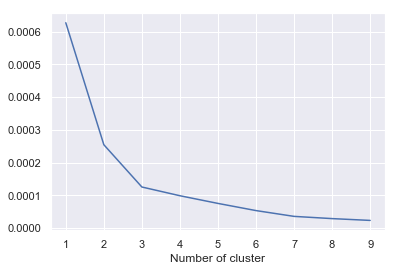

In [9]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Deceide 3 as the optimal cluster number based on change of curve slope 

then divide and calculate cluster labels 

In [12]:
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(X)

X['Cluster'] = kmeans.labels_
X['Color'] = X['Cluster'].map(
    lambda x: 'maroon' if x == 0 else ('darkviolet' if x == 1 else 'navy'))

map_ = folium.Map(location=[X['Latitude'].mean(), X['Longitude'].mean()], zoom_start=15)

# add markers to map
for lat, lng, clr in zip(X['Latitude'], X['Longitude'], X['Color']):
    label = ''
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=clr,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  

map_

C:\Users\thane\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\thane\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


__Foursquare credentials, version and other settings__

define a function getNearbyVenues to crawl venue dataset

In [13]:
CLIENT_ID = 'GS1PJP1MBR0R31F0M3HMZN2MRDCG1CIQBADBMWQ3UTZWG0DX'
CLIENT_SECRET = 'GAR4ADS2Z1CTU40RIU5AO11BLQXHF2T2COX3XHBTI34PKQCZ'
VERSION = '20200131'

# define radius and limit of venues to get
RADIUS=500
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500, show_names=False):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        if show_names:
            print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Crawl middle position's neighbor venues in every cluster instead of every building to avoid many duplicate calculations. 

In [14]:
neighbor = pd.DataFrame()

neighbor['Latitude'] = X.groupby('Color').Latitude.mean()
neighbor['Longitude'] = X.groupby('Color').Longitude.mean()

neighbor = neighbor.reset_index()

print(neighbor)

venues = getNearbyVenues(names=neighbor['Color'], latitudes=neighbor['Latitude'], longitudes=neighbor['Longitude'], radius=RADIUS)

print(venues.tail())

        Color   Latitude  Longitude
0  darkviolet  50.111793   8.672510
1      maroon  50.115334   8.667863
2        navy  50.110535   8.662603
    Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
204         navy              50.110535                8.662603   
205         navy              50.110535                8.662603   
206         navy              50.110535                8.662603   
207         navy              50.110535                8.662603   
208         navy              50.110535                8.662603   

              Venue  Venue Latitude  Venue Longitude    Venue Category  
204        Zapfhahn       50.106695         8.665300               Pub  
205     Hotel TOPAS       50.107836         8.659303             Hotel  
206   Bristol Hotel       50.107748         8.658772             Hotel  
207         Dunkin'       50.106515         8.663717        Donut Shop  
208  Asia Call Food       50.107297         8.657829  Asian Restaurant  


Extract nearby venues informations.

semi-automatic product over group of venue category. 

In [15]:
df_venue = venues.loc[:, ('Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category')]
df_venue.drop_duplicates(inplace=True)
df_venue = df_venue.reset_index()[['Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']]
df_venue.to_csv('bankenviertel_venue_detail.csv', index=False, sep=';', encoding='utf-8')
print(df_venue.shape)
df_venue = df_venue.loc[:, ('Venue Category')].reset_index()[['Venue Category']]
df_venue.drop_duplicates(inplace=True)
df_venue.to_csv('bankenviertel_venue_category.csv', index=False, sep=';', encoding='utf-8')
print(df_venue.shape)

(180, 4)
(77, 1)


__Read geometric data directly from saved file and prepare subset for map plotting and venue calculation__

plot skyscrapers in Canary Wharf, London with folium

In [16]:
# read geo data directly.
df = pd.read_csv('canary_wharf_with_coordinate.csv', sep=';', encoding='utf-8')

X = df[['Latitude', 'Longitude']]

map_ = folium.Map(location=[X['Latitude'].mean(), X['Longitude'].mean()], zoom_start=15)

# add markers to map
for lat, lng in zip(X['Latitude'], X['Longitude']):
    label = ''
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  

map_

__Determine cluster number with K Means method__ 

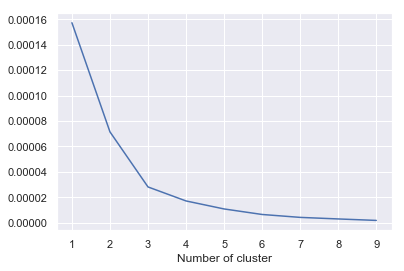

In [17]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Deceide 3 as the optimal cluster number based on change of curve slope 

then divide and calculate cluster labels 

In [18]:
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(X)
X['Cluster'] = kmeans.labels_

X['Color'] = X['Cluster'].map(lambda x: 'maroon' if x == 0 else ('darkviolet' if x == 1 else 'navy'))

map_ = folium.Map(location=[X['Latitude'].mean(), X['Longitude'].mean()], zoom_start=15)

# add markers to map
for lat, lng, clr in zip(X['Latitude'], X['Longitude'], X['Color']):
    label = ''
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=clr,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  

map_

Crawl middle position's neighbor venues in every cluster instead of every building to avoid many duplicate calculations. 

In [19]:
neighbor = pd.DataFrame()

neighbor['Latitude'] = X.groupby('Color').Latitude.mean()
neighbor['Longitude'] = X.groupby('Color').Longitude.mean()

neighbor = neighbor.reset_index()

print(neighbor)

venues = getNearbyVenues(names=neighbor['Color'], latitudes=neighbor['Latitude'], longitudes=neighbor['Longitude'], radius=RADIUS)

print(venues.tail())

        Color   Latitude  Longitude
0  darkviolet  51.506145  -0.022987
1      maroon  51.504166  -0.018769
2        navy  51.504216  -0.014073
    Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
295         navy              51.504216               -0.014073   
296         navy              51.504216               -0.014073   
297         navy              51.504216               -0.014073   
298         navy              51.504216               -0.014073   
299         navy              51.504216               -0.014073   

                       Venue  Venue Latitude  Venue Longitude  \
295                    Pocho       51.505891        -0.015778   
296         T4 (Tea for you)       51.505703        -0.016591   
297       Lemongrass Kitchen       51.500358        -0.017415   
298       Poplar Dock Marina       51.506412        -0.008636   
299  Docklands Scout Project       51.501033        -0.010022   

       Venue Category  
295        Taco Place  
296   Bubble T

Extract nearby venues informations.

semi-automatic product over group of venue category. 

In [20]:
bv_grp = pd.read_csv('bankenviertel_venue_group.csv', sep=',', encoding='utf-8')

df_venue = venues.loc[:, ('Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category')]
df_venue.drop_duplicates(inplace=True)
df_venue = df_venue.reset_index()[['Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']]
df_venue.to_csv('canary_wharf_venue_detail.csv', index=False, sep=';', encoding='utf-8')
print(df_venue.shape)
df_venue = df_venue.loc[:, ('Venue Category')].reset_index()[['Venue Category']]
df_venue.drop_duplicates(inplace=True)
df_venue = pd.merge(df_venue, bv_grp, how='left', on=['Venue Category'])
df_venue.to_csv('canary_wharf_venue_category.csv', index=False, sep=';', encoding='utf-8')
print(df_venue.shape)

(150, 4)
(81, 2)


__Read geometric data directly from saved file and prepare subset for map plotting and venue calculation__

plot skyscrapers in City of London, London with folium

In [21]:
# read geo data directly.
df = pd.read_csv('city_of_london_with_coordinate.csv', sep=';', encoding='utf-8')

X = df[['Latitude', 'Longitude']]

map_ = folium.Map(location=[X['Latitude'].mean(), X['Longitude'].mean()], zoom_start=15)

# add markers to map
for lat, lng in zip(X['Latitude'], X['Longitude']):
    label = ''
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  

map_

__Determine cluster number with K Means method__ 

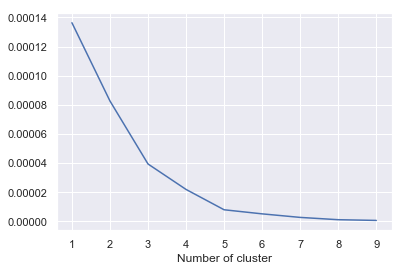

In [22]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Deceide 5 as the optimal cluster number based on change of curve slope 

then divide and calculate cluster labels 

In [23]:
kmeans = KMeans(n_clusters=5, max_iter=1000).fit(X)
X['Cluster'] = kmeans.labels_

X['Color'] = X['Cluster'].map(
    lambda x: 'maroon' if x == 0 else ('darkviolet' if x == 1 else ('navy' if x == 2 else ('green' if x == 3 else 'red'))))

map_ = folium.Map(location=[X['Latitude'].mean(), X['Longitude'].mean()], zoom_start=15)

# add markers to map
for lat, lng, clr in zip(X['Latitude'], X['Longitude'], X['Color']):
    label = ''
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=clr,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  

map_

C:\Users\thane\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Crawl middle position's neighbor venues in every cluster instead of every building to avoid many duplicate calculations.

In [24]:
neighbor = pd.DataFrame()

neighbor['Latitude'] = X.groupby('Color').Latitude.mean()
neighbor['Longitude'] = X.groupby('Color').Longitude.mean()

neighbor = neighbor.reset_index()

print(neighbor)

venues = getNearbyVenues(names=neighbor['Color'], latitudes=neighbor['Latitude'], longitudes=neighbor['Longitude'], radius=RADIUS)

print(venues.tail())

        Color   Latitude  Longitude
0  darkviolet  51.515307  -0.081481
1       green  51.512599  -0.082621
2      maroon  51.520435  -0.078947
3        navy  51.519528  -0.088202
4         red  51.514942  -0.085140
    Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
394          red              51.514942                -0.08514   
395          red              51.514942                -0.08514   
396          red              51.514942                -0.08514   
397          red              51.514942                -0.08514   
398          red              51.514942                -0.08514   

                    Venue  Venue Latitude  Venue Longitude  \
394         Pret A Manger       51.514550        -0.081059   
395         Another Space       51.515053        -0.090384   
396      DW Fitness First       51.511221        -0.084645   
397          Coq d'Argent       51.513303        -0.091036   
398  Crafty Fellas London       51.512581        -0.083402   

        

Extract nearby venues informations.

semi-automatic product over group of venue category. 

In [25]:
cw_grp = pd.read_csv('canary_wharf_venue_group.csv', sep=',', encoding='utf-8')
group = pd.concat([bv_grp, cw_grp])
group.drop_duplicates(inplace=True)

df_venue = venues.loc[:, ('Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category')]
df_venue.drop_duplicates(inplace=True)
df_venue = df_venue.reset_index()[['Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']]
df_venue.to_csv('city_of_london_venue_detail.csv', index=False, sep=';', encoding='utf-8')
print(df_venue.shape)
df_venue = df_venue.loc[:, ('Venue Category')].reset_index()[['Venue Category']]
df_venue.drop_duplicates(inplace=True)
df_venue = pd.merge(df_venue, group, how='left', on=['Venue Category'])
df_venue.to_csv('city_of_london_venue_category.csv', index=False, sep=';', encoding='utf-8')
print(df_venue.shape)

(262, 4)
(101, 2)


## Analyse difference between venues in Frankfurt and London

In [26]:
bv_grp = pd.read_csv('bankenviertel_venue_group.csv', sep=',', encoding='utf-8')
cw_grp = pd.read_csv('canary_wharf_venue_group.csv', sep=',', encoding='utf-8')
cl_grp = pd.read_csv('city_of_london_venue_group.csv', sep=',', encoding='utf-8')

bv_venue = pd.read_csv('bankenviertel_venue_detail.csv', sep=';', encoding='utf-8')
cw_venue = pd.read_csv('canary_wharf_venue_detail.csv', sep=';', encoding='utf-8')
cl_venue = pd.read_csv('city_of_london_venue_detail.csv', sep=';', encoding='utf-8')

group = pd.concat([cl_grp, cw_grp])
group.drop_duplicates(inplace=True)

unique = pd.merge(bv_grp, group, how='left', on=['Venue Category'], suffixes=['', '_'])
unique = unique[unique['Venue Group_'].isnull()][['Venue Category', 'Venue Group']]
ff_unique = pd.merge(bv_venue, unique, how='right', on=['Venue Category'])
print(ff_unique.head())

ff_unique = ff_unique.groupby(['Venue Category', 'Venue Group']).size().reset_index(name='Count') 

                      Venue  Venue Latitude  Venue Longitude Venue Category  \
0                     MMK 2       50.110207         8.672162     Art Museum   
1                Goethehaus       50.111288         8.677794     Art Museum   
2                Main Tower       50.112464         8.672185       Building   
3  MEYER Feinkost Frankfurt       50.114819         8.673398   Gourmet Shop   
4          Marshall-Brunnen       50.114530         8.671110       Fountain   

  Venue Group  
0   Free time  
1   Free time  
2   Free time  
3   Free time  
4   Free time  


In [27]:
venue = pd.concat([cl_venue, cw_venue])
venue.drop_duplicates(inplace=True)

unique = pd.merge(group, bv_grp, how='left', on=['Venue Category'], suffixes=['', '_'])
unique = unique[unique['Venue Group_'].isnull()][['Venue Category', 'Venue Group']]
ld_unique = pd.merge(venue, unique, how='right', on=['Venue Category'])
print(ld_unique.head())

ld_unique = ld_unique.groupby(['Venue Category', 'Venue Group']).size().reset_index(name='Count') 
ld_unique

                            Venue  Venue Latitude  Venue Longitude  \
0  Swingers - The Crazy Golf Club       51.514202        -0.080383   
1                   Assenheims 56       51.516228        -0.082458   
2                    KERB Gherkin       51.514803        -0.080643   
3                        Dinerama       51.523261        -0.079233   
4            KERB West India Quay       51.508925        -0.024008   

          Venue Category        Venue Group  
0              Mini Golf              Sport  
1   Colombian Restaurant  Catering Services  
2  Street Food Gathering  Catering Services  
3  Street Food Gathering  Catering Services  
4  Street Food Gathering  Catering Services  


,Venue Category,Venue Group,Count
0,American Restaurant,Catering Services,1
1,Argentinian Restaurant,Catering Services,4
2,Art Gallery,Free time,1
3,Athletics & Sports,Sport,1
4,BBQ Joint,Catering Services,2
...,...,...,...
74,Turkish Restaurant,Catering Services,4
75,Whisky Bar,Catering Services,1
76,Wine Bar,Catering Services,6
77,Wine Shop,Catering Services,2


         Venue Category        Venue Group  Count
41   Italian Restaurant  Catering Services     14
35                Hotel            Lodging     12
13                 Café  Catering Services      7
16          Coffee Shop  Catering Services      7
66           Steakhouse  Catering Services      6
1      Asian Restaurant  Catering Services      6
29    German Restaurant  Catering Services      6
42  Japanese Restaurant  Catering Services      5
2                Bakery  Catering Services      5
58           Restaurant  Catering Services      5
           Venue Category        Venue Group  Count
27            Coffee Shop  Catering Services     27
63                  Hotel            Lodging     25
59   Gym / Fitness Center              Sport     19
67     Italian Restaurant  Catering Services     16
102        Sandwich Place  Catering Services     15
20                   Café  Catering Services     11
99             Restaurant  Catering Services      9
26           Cocktail Bar  Caterin

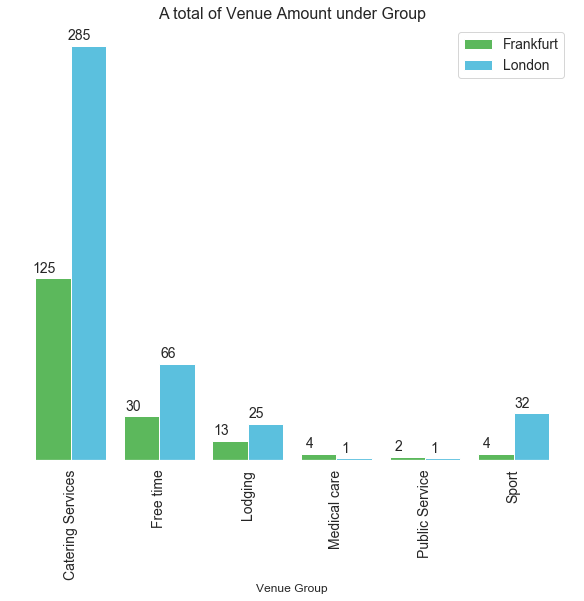

In [28]:
ff_venue = pd.merge(bv_venue, bv_grp, how='left', on=['Venue Category'])

ff_venue = ff_venue.groupby(['Venue Category', 'Venue Group']).size().reset_index(name='Count')
print(ff_venue.sort_values(by='Count', ascending=False).head(10))

ff_plot = ff_venue.groupby('Venue Group')['Count'].sum().to_frame(name='Frankfurt')

ld_venue = pd.concat([cl_venue, cw_venue])

ld_venue = pd.merge(ld_venue, group, how='left', on=['Venue Category'])

ld_venue = ld_venue.groupby(['Venue Category', 'Venue Group']).size().reset_index(name='Count')
print(ld_venue.sort_values(by='Count', ascending=False).head(10))

ld_plot = ld_venue.groupby('Venue Group')['Count'].sum().to_frame(name='London')

unique = pd.merge(ff_plot, ld_plot, how='outer', on=('Venue Group'))

print(unique)

# Plotting
ax = unique.plot(kind='bar', figsize=(10, 8), rot=90, color = ['#5cb85c','#5bc0de'], width=.8, fontsize=14)

# Setting plot title
ax.set_title('A total of Venue Amount under Group', fontsize=16)

# Setting figure background color
ax.set_facecolor('white')

# setting legend font size
ax.legend(fontsize=14, facecolor = 'white') 

# Removing the Border 
ax.get_yaxis().set_visible(False)

# Creating a loop to display the percentage.
for p in ax.patches:
     ax.annotate('{:}'.format(p.get_height()), (p.get_x()+p.get_width()/4, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize = 14)
   

                   Frankfurt  London
Venue Group                         
Catering Services     0.7022  0.6951
Free time             0.1685  0.1610
Lodging               0.0730  0.0610
Medical care          0.0225  0.0024
Public Service        0.0112  0.0024
Sport                 0.0225  0.0780


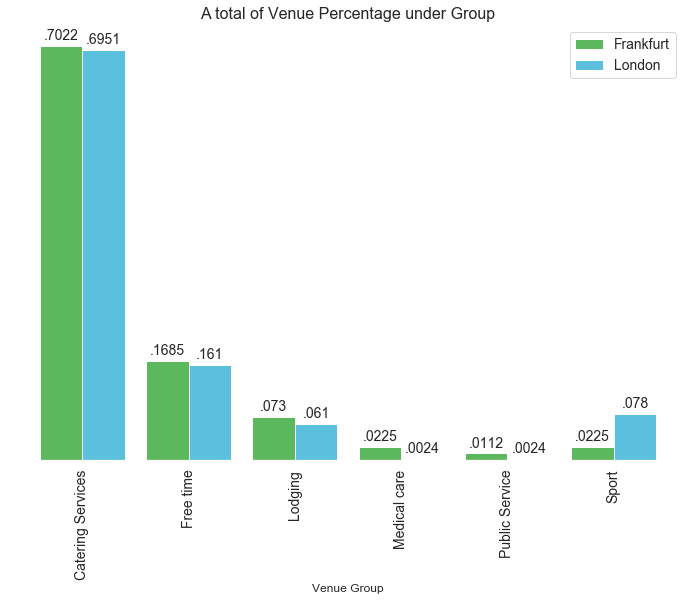

In [29]:
ff_pct = round(ff_plot/ff_plot.sum(), 4)

ld_pct = round(ld_plot/ld_plot.sum(), 4)

unique = pd.merge(ff_pct, ld_pct, how='outer', on=('Venue Group'))
print(unique)

# Plotting
ax = unique.plot(kind='bar', figsize=(12, 8), rot=90, color = ['#5cb85c','#5bc0de'], width=.8, fontsize=14)

# Setting plot title
ax.set_title('A total of Venue Percentage under Group', fontsize=16)

# Setting figure background color
ax.set_facecolor('white')

# setting legend font size
ax.legend(fontsize=14, facecolor = 'white') 

# Removing the Border 
ax.get_yaxis().set_visible(False)

# Creating a loop to display the percentage.
for p in ax.patches:
     ax.annotate('{:}'.format(p.get_height()).replace('0.', '.'), (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize = 14)


                   Bankenviertel  City of London  Canary Wharf
Venue Group                                                   
Catering Services          0.702           0.697         0.691
Free time                  0.169           0.146         0.188
Lodging                    0.073           0.073         0.040
Medical care               0.022             NaN         0.007
Public Service             0.011             NaN         0.007
Sport                      0.022           0.084         0.067


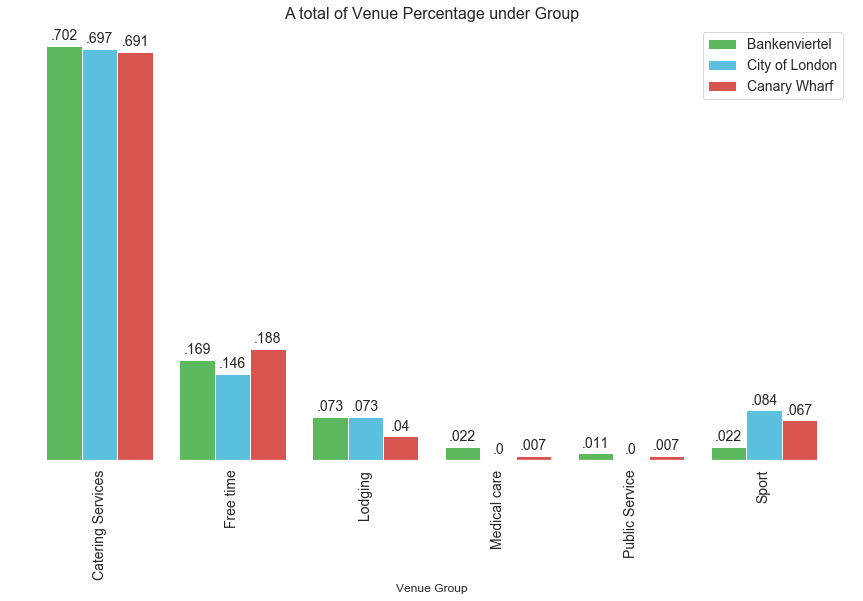

In [30]:
df_bv = pd.merge(bv_venue, bv_grp, how='left', on=['Venue Category'])

df_bv = df_bv.groupby(['Venue Category', 'Venue Group']).size().reset_index(name='Count')

bv_plot = df_bv.groupby('Venue Group')['Count'].sum().to_frame(name='Bankenviertel')

bv_pct = round(bv_plot/bv_plot.sum(), 3)

df_cl = pd.merge(cl_venue, cl_grp, how='left', on=['Venue Category'])

df_cl = df_cl.groupby(['Venue Category', 'Venue Group']).size().reset_index(name='Count')

cl_plot = df_cl.groupby('Venue Group')['Count'].sum().to_frame(name='City of London')

cl_pct = round(cl_plot/cl_plot.sum(), 3)

unique = pd.merge(bv_pct, cl_pct, how='outer', on=('Venue Group'))

df_cw = pd.merge(cw_venue, cw_grp, how='left', on=['Venue Category'])

df_cw = df_cw.groupby(['Venue Category', 'Venue Group']).size().reset_index(name='Count')

cw_plot = df_cw.groupby('Venue Group')['Count'].sum().to_frame(name='Canary Wharf')

cw_pct = round(cw_plot/cw_plot.sum(), 3)

unique = pd.merge(unique, cw_pct, how='outer', on=('Venue Group'))
print(unique)

# Plotting
ax = unique.plot(kind='bar', figsize=(15, 8), rot=90, color = ['#5cb85c','#5bc0de','#d9534f'], width=.8, fontsize=14)

# Setting plot title
ax.set_title('A total of Venue Percentage under Group', fontsize=16)

# Setting figure background color
ax.set_facecolor('white')

# setting legend font size
ax.legend(fontsize=14, facecolor = 'white') 

# Removing the Border 
ax.get_yaxis().set_visible(False)

# Creating a loop to display the percentage.
for p in ax.patches:
     ax.annotate('{:}'.format(p.get_height()).replace('0.', '.'), (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize = 14)


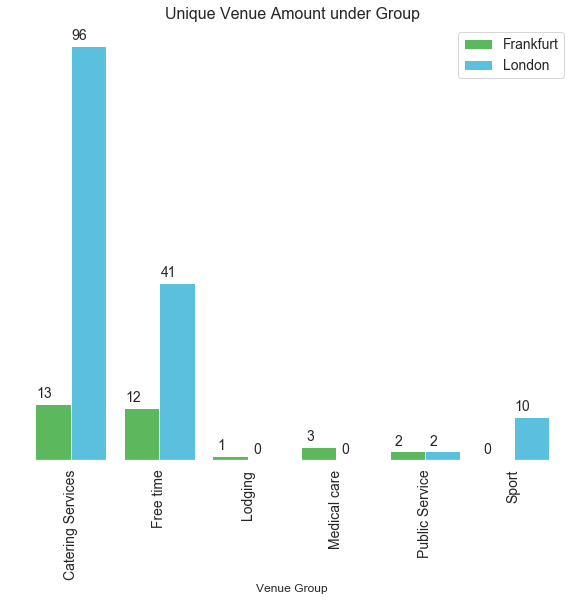

In [31]:
ff_plot = ff_unique.groupby('Venue Group')['Count'].sum().to_frame(name='Frankfurt')

ld_plot = ld_unique.groupby('Venue Group')['Count'].sum().to_frame(name='London')

unique = pd.merge(ff_plot, ld_plot, how='outer', on=('Venue Group'))

#print(unique)

# Plotting
ax = unique.plot(kind='bar', figsize=(10, 8), rot=90, color = ['#5cb85c','#5bc0de'], width=.8, fontsize=14)

# Setting plot title
ax.set_title('Unique Venue Amount under Group', fontsize=16)

# Setting figure background color
ax.set_facecolor('white')

# setting legend font size
ax.legend(fontsize=14, facecolor = 'white') 

# Removing the Border 
ax.get_yaxis().set_visible(False)

# Creating a loop to display the percentage.
for p in ax.patches:
     ax.annotate('{:}'.format(round(p.get_height(), 2)).replace('.0', ''), (p.get_x()+p.get_width()/4, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize = 14)
